# Performing iterature review with text embeddings.
This notebook is a guide through our method for performing a literature review on text data with embeddings, which are numerical representations of a text's semantic meaning. It takes you all the way from importing the right packages to plotting the resulting results.

The notebook is divided into six parts listed beneath. You will be taken to the listed part by pressing the corresponding hyperlink.

1. [Imports](#imports) <br>
2. [Make embeddings](#load-embeddings-and-expert-indices)<br>
3. [Create centroids](#create-function) <br>
4. [Scoring texts](#scoring_function) <br>
5. [Histogram](#histogram)<br>
6. [Heatmap](#heatmap)<br>


<a class="anchor" id="imports"></a>

## 1. Imports
The following imports are necessary to apply our method.

In [3]:
# Importing the transformer
!pip install sentence_transformers --quiet
!pip install seaborn
from sentence_transformers import SentenceTransformer

# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy as sc

# Special imports for plots
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Imports for the widgets
from ipywidgets import widgets
from IPython.display import display, clear_output

DEPRECATION: Loading egg at c:\users\2002a\work\coding\conda\envs\embed\lib\site-packages\sacremoses-0.0.43-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 435.7 kB/s eta 0:00:01
   -------- ------------------------------ 61.4/294.9 kB 544.7 kB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.8 MB/s eta 0:00:00


DEPRECATION: Loading egg at c:\users\2002a\work\coding\conda\envs\embed\lib\site-packages\sacremoses-0.0.43-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


<a class="anchor" id="load_embeddings_and_expert_indices"></a>

## 2. Load data and make embeddings
Load the data into a pandas DataFrame. Remember to make sure that the filepath is correct. The data should include a column with the text data.

In [17]:
df = pd.read_csv("https://raw.githubusercontent.com/Abdma03/INTED/main/Small%20dataset%20textembedding%201.csv", encoding="Windows-1252")
df.head()

,Data;;;;
0,I am really interested in artificial intellige...
1,I wanted to be challenged academically speakin...
2,I thought it would be a good opportunity to co...
3,I wanted to learn more about artificial intell...
4,It offered an interdisciplinary education whic...


To embed the articles we use the Sentence Transformer library, to download an embedding model. The library has a large number of pre-trained models, and we use a model from MixedBread AI called mxbai-embed-large-v1. This was chosen because it is a light model with solid performance on MTEB.

In [18]:
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

c:\Users\2002a\Work\Coding\Conda\envs\embed\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


With the model sucsessfully loaded and the bars turned green, are we ready to use to model. It is as simple as calling **model.encode()**, with the text as input.

We want to store the embeddings together with all the text and other potential metadata already present in our DataFrame. We therefore create a new column in the DataFrame called "embedding". Since our model will output a vector of length 1024, we store the vector as a list of 1024 elements. The dimensionality will vary between models so it is important to check the documentation of the model you are using, to see which dimensionality it is operating with. Common ones are 512, 768, 1536, and 3072.

The below code loops over each row in the DataFrame, embeds the text at that row and then stores it back into the DataFrame. The output is a list of lists, where each list is the embedding of the corresponding text.

In [22]:
embedding = model.encode(df["Data;;;;"])
embedding = embedding.tolist()
df.insert(1,"embedding",embedding)

Now, it is useful to inspect the DataFrame to make sure everything is in order. You should see a new column called **embedding** having emerged, filled with numbers in a list.

In [23]:
df.head()

,Data;;;;,embedding
0,I am really interested in artificial intellige...,"[-0.36321955919265747, 0.0804968848824501, -0...."
1,I wanted to be challenged academically speakin...,"[0.0946253091096878, -0.8166891932487488, -0.2..."
2,I thought it would be a good opportunity to co...,"[0.08060890436172485, -0.19674721360206604, -0..."
3,I wanted to learn more about artificial intell...,"[0.06022772938013077, 0.026954127475619316, -0..."
4,It offered an interdisciplinary education whic...,"[-0.10069331526756287, -0.1622166484594345, -0..."


For the calculations later on, it is useful to single out only the embeddings. Let us put these in a matrix.

In [24]:
text_embeddings = np.vstack(df["embedding"].values)
print(text_embeddings.shape)

(25, 1024)


## 3. Create centroids

The next step is to identify interesting points in space, called centroids. Centroids are the vector representation of the topic/class/theme etc. in the embedding space. There are two ways of identifying these spaces' vectors.

A: The first way is to take the mean of the vectors of representative texts for each category.

B: The second way is to embed a specialized text, formatted to represent the category you are looking for.

We will show both options. You should do **EITHER** A **OR** B, but not both. Both options will end with a list of embeddings, representing the categories in the embedding space.

#### 3A. Representative texts
To do the first approach, you need two lists of equal length. We call these lists centroid_indices and category_names.

- centroid_indices should be list of lists. The sublists have indices in them, which are the indices of the texts that you have selected as the representative texts for that category.
- category_names should be a list of strings with the names of the different categories you have - typically the codes.

Under we show how this would look if we had 3 categories.

```python
centroid_indices = [[3, 7, 18], [27, 14, 23], [53, 12, 9]]
category_names = ['category 1', 'category 2', 'category 3']
```
Here the texts with index 3, 7 and 18 are considered to be representative of category 1. Texts 27, 14 and 23 are representative of category 2, and texts 53, 12 and 9 are representative of category 3.

Beneath, we have picked out some representative texts (via the range function) and categories for the dataset that is downloaded from GitHub.

In [27]:
# For our mock dataset we suggest you use these indices
centroid_indices = [23,15,9]
category_names = ["Career", "Social", "Learning"]

The next step is to fetch these embeddings, and calculate their mean. This will generate a single point in the high dimensional embedding space, which is where the category is situated. We will create an empty list called centroid_embeddings, and fill it with the mean of the embeddings per category.

In [29]:
centroid_embeddings = []

for category in centroid_indices:
  category_embeddings = []
  """for index in category: category_embeddings.append(df.embedding[index])
  category_embedding_centroid = np.mean(category_embeddings, axis=0)
  centroid_embeddings.append(category_embedding_centroid)"""

centroid_embeddings = np.array(centroid_embeddings)

Now we have n=number of categories number of points in space, that represent these categories!

#### 3B. Curated text for embeddings
To do the second approach, you need two lists of equal length. Here, we call these lists centroid_texts and again category_names.

- centroid_texts should be list of lists. The sublists should have strings in them, which is the text you think is representative for that category.
- category_names should be a list of strings with the names of the different categories you have - typically the codes.

Under we show how this would look if we had 3 categories, and wrote three representative texts per category. In reality, you choose what and how many representative texts you wish to write.

```python
centroid_texts = [["representative text for category 1", "another representative text", "a third typical example of what the archtype of category 1 text looks like"], ["representative text for category 2", "another representative text", "a third typical example of what the archtype of category 2 text looks like"], ["representative text for category 3", "another representative text", "a third typical example of what the archtype of category 3 text looks like"]]
category_names = ['category 1', 'category 2', 'category 3']
```


For longer texts and greater control, we suggest writing these texts externally, and then loading them into a list called centroid_texts. Make sure the format is right.

Beneath, we have written some representative texts and categories for the dataset that is downloaded from GitHub.

In [31]:
# For our mock dataset we suggest you use these texts
centroid_texts = [["I heard good rumours about the studyprogram."],["I chose it because it seemed somewhat interesting and I had the grades to get in. I thought what do I have to lose? Worst case scenario I drop out and continue a regular bachelor."],["I was thinking that the other students would be driven and interested which would contribute to a unique study experience and environment"]]
category_names = ["Career", "Social", "Learning"]

The next step is to embed this texts, and calculate the mean of their embeddings. Here, as always, we call the model.encode() function. For each category, we embed the curated text, take their mean, and append that vector to the list

In [32]:
centroid_embeddings = []

for category in centroid_texts:
  category_embeddings = []
  for representative_text in category:
    representative_text_embedding = model.encode(representative_text)
    category_embeddings.append(representative_text_embedding)
  category_embedding_centroid = np.mean(category_embeddings, axis=0)
  centroid_embeddings.append(category_embedding_centroid)


centroid_embeddings = np.array(centroid_embeddings)

Now we have n=number of categories number of points in space, that represent these categories!

<a class="anchor" id="scoring_function"></a>

## 4. Scoring texts

The next step is to score each text. We calculate a text's score in each category, by measuring the similarity of every article to every centroid. This is done by calculating the distance from the embedding vector of an article to a centroid.

Since we are operating in a space with numerous dimensions, it is possible to choose from a variety of metrics for measuring the distance. Common metrics include Euclidean, Manhattan/Cityblock, and Cosine Similarity. Our preferred metric is Cosine Similarity.

Another feature of a high-dimensional space is that all distances tend to be similar. However, small changes in distance have large semantical implications. There is therefore a need for a scaling mechanism. There are several choices for a scaling algorithm, but we have singled out two promising paths - the power scale or the exponential scale.

Both alternatives present a tunable scaling variable $\alpha$, which helps determine the how mixed the model is. Finding a meaningful alpha value is important, and will be a key point of argument.

Finally, as we want all articles to fully belong to something, the scores are normalized for comparability.

In [33]:
def embedding_score(text_embeddings, centroid_embeddings, alpha, metric, scaling, rounding=False):

    # Check that the input is valid
    assert scaling in ["exponential", "power"]
    assert metric in ["cosine", "euclidean", "cityblock"]

    # Calculating distances using scipy.spatial.distance.cdist function
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    distances = sc.spatial.distance.cdist(text_embeddings, centroid_embeddings, metric=metric)

    # Scale and invert the distances according to the specified scaling
    if scaling == "exponential":
        score = 1/np.exp(alpha*distances)
    if scaling == "power":
        score = 1/(distances**alpha)

    # L1 norm the scores to get a probability distribution
    score /= score.sum(axis=1)[:,None]

    # Round the scores to 2 decimals if specified
    if rounding:
        # Set all values below 0.01 to 0
        score[score <=0.01] = 0
        score /= score.sum(axis=1)[:,None]

    return score

What parameters to select will be dependent on the data you have. For now, let us set some initial values.

In [34]:
texts = text_embeddings   # the matrix of all the embeddings from earlier
centroids = centroid_embeddings   # the embedded centroids we made in part 3

alpha = 50    # an initial alpha value
metric = 'cosine'   # Cosine Similarity
scaling = 'power'   # Power scaling

Having these values, let us calculate and look at some scores.

In [35]:
scores = embedding_score(texts, centroids, alpha, metric, scaling)

print(scores[:5])

[[8.37360793e-06 2.35756146e-03 9.97634065e-01]
 [4.37753598e-10 8.49125621e-06 9.99991508e-01]
 [4.67923353e-08 3.14890133e-08 9.99999922e-01]
 [1.70855235e-05 6.78226964e-05 9.99915092e-01]
 [1.27282377e-09 8.54363343e-09 9.99999990e-01]]


What we see here is that these scores have very little mixedness - that is, each sentence firmly belongs to one camp. This is the mixedness that can be tuned by the alpha parameter. Let us try again, with alpha at 1.

In [36]:
texts = text_embeddings   # the matrix of all the embeddings from earlier
centroids = centroid_embeddings   # the embedded centroids we made in part 3

alpha = 1    # an initial alpha value
metric = 'cosine'   # Cosine Similarity
scaling = 'power'   # Power scaling

scores = embedding_score(texts, centroids, alpha, metric, scaling)

print(scores[:5])

[[0.29561682 0.33091782 0.37346536]
 [0.26616433 0.32426845 0.40956722]
 [0.29467053 0.29234549 0.41298398]
 [0.30548665 0.31402713 0.38048622]
 [0.28208032 0.29302878 0.4248909 ]]


Here, the texts show a much more homogeneous score distribution. A helpful tool for determining what hyperparameters to use is a histogram.  

<a class="anchor" id="histogram"></a>

## 5. Histogram

We use histograms of the score distributions to easily determine the alpha value based on the desired mixedness of the model. Different models and different datasets require different kinds of distribution. The plot shows how high the primary, secondary, etc. scores are.

Below, we create a function for plotting the histogram, and another for updating it.

In [41]:
# @title Plotting functions for histogram
# Plotting function
def plot_histogram(alpha, metric, scaling, nr_of_hist):

    # Create the scores from alpha, metric and scaling
    scores = embedding_score(text_embeddings, centroid_embeddings, alpha, metric, scaling)

    #color and shading for plotting
    colors = [plt.cm.viridis(i) for i in np.linspace(0, 1, nr_of_hist)]
    alpha_shading = np.linspace(1, 0.4, nr_of_hist)

    # Plot the histogram in figure
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(nr_of_hist):
        plot_data = np.partition(scores, -i-1, axis=1)[:, -i-1]
        # plot_data is the number i+1 largest value in scores, across all scores
        # Plot histogram
        ax.hist(plot_data, bins=50, alpha=alpha_shading[i], color=colors[i])

    # Make plot nice
    ax.set_ylabel("Count")
    ax.set_xlabel("Score")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(left=0, right=1)
    fig.tight_layout(pad=3.0)

    # Legend creation
    labels = [f'{i+1}. score' for i in range(nr_of_hist)]
    handles = [mpatches.Patch(color=colors[i], label=f'Hist {i+1}') for i in range(nr_of_hist)]
    fig.legend(handles=handles, labels=labels, loc='right')
    plt.show()


# Callback for updating histogram
def update_histogram(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output(wait=True)
            plot_histogram(alpha_slider.value, metric_selector.value, scaling_selector.value, nr_of_hist_selector.value)


Having defined these functions, we create an interactive tool useful for exploring different hyperparameters.

In [42]:
# @title Interactive tool
# Widgets
metric_selector = widgets.RadioButtons(
    options=['euclidean', 'cosine', 'cityblock'],
    description='Metric:',
    value = 'cosine',
    tooltip='Select the metric for calculating the distance'
    )
scaling_selector = widgets.RadioButtons(
    options=['power', 'exponential'],
    description='Scaling:', value='exponential',
    tooltip='Select the scaling type for the scores'
    )
alpha_slider = widgets.FloatSlider(
    value=15, min=0.0, max=300.0, description='Alpha:',
    continuous_update=True,
    tooltip='Select the amount of scaling'
    )
nr_of_hist_selector = widgets.IntSlider(
    value=3, min=1, max=len(category_names),
    step=1, description='Nr of histograms:',
    continuou_update=True,
    tooltip='Select the number of histograms to display'
    )

alpha_slider.observe(update_histogram, names='value')
metric_selector.observe(update_histogram, names='value')
scaling_selector.observe(update_histogram, names='value')
nr_of_hist_selector.observe(update_histogram, names='value')

# Output widget
output = widgets.Output()

# Display initial histogram
with output:
    plot_histogram(alpha_slider.value, metric_selector.value, scaling_selector.value, nr_of_hist_selector.value)

# First line of widgets
first_line = widgets.HBox([metric_selector, scaling_selector, nr_of_hist_selector])

# Alpha slider with an extended width
alpha_slider.layout = widgets.Layout(width='100%')  # Adjust the width percentage as needed

# Second line of widgets (alpha slider)
second_line = widgets.HBox([alpha_slider], layout=widgets.Layout(justify_content='center'))

# Combine both lines in a VBox
widget_box = widgets.VBox([first_line, second_line, output])

display(widget_box)

<a class="anchor" id="heatmap"></a>

## 6. Heatmap

Having set a preliminary alpha value based on the histogram, it may be useful to inspect individual texts. A heatmap provides a way of getting some face validity on the actual data points, as it showes the scores of individual texts in a simple and informative manner. Below, we define the plotting function and a function for updating the heatmap.

In [43]:
# @title Plotting function for heatmap
def plot_heatmap(indices, alpha, metric, scaling, category_names):
    import string
    alphabet = list(string.ascii_lowercase)

    red_colors = [(1, 0.95, 0.95), (1, 0.9, 0.9), (1, 0.4, 0.5),
                  (0.95, 0.3, 0.4), (0.95, 0.2, 0.3), (0.7, 0.1, 0.2),
                   (0.5, 0.08, 0.15)]
    red_cmap = mcolors.LinearSegmentedColormap.from_list("custom", red_colors, N=256)

    # Plot heatmaps for all five articles as subplots in one figure
    fig, ax = plt.subplots(len(indices),1, figsize=(10, len(indices)+2))
    embedding_scores = embedding_score(text_embeddings, centroid_embeddings, alpha, metric, scaling)

    # Create each of the subplot heatmaps
    for i, index in enumerate(indices):
        scores = np.vstack(embedding_scores[index, :]).T
        gx = sns.heatmap(scores, cmap=red_cmap, annot=True, yticklabels=['Score'],
                         xticklabels=range(1,len(category_names)+1), vmin=0, vmax=1, ax=ax[i], cbar=False, fmt='.2f')

        # extra formating of the plot
        gx.set_yticklabels(gx.get_yticklabels(), fontsize=9)
        ax[i].text(-0.3, -0.2, f"({alphabet[i]})", fontsize=11, fontweight='bold')

        # This line might need changes in order to be more usefull
        ax[i].set_title(f'{df["text"][index]}', fontweight='bold', fontsize=10)


    legend_patches = [mpatches.Patch(color='white', label=(f'{i+1}: {category}')) for i, category in enumerate(category_names)]
    fig.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.95), loc='upper left', frameon = False, ncol=1, prop={'size': 10, 'weight':'bold'})
    fig.tight_layout(w_pad=2, h_pad=2)
    plt.show()


def update_heatmap(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output(wait=True)
            scores = embedding_score(text_embeddings,
                                     centroid_embeddings,
                                     alpha_slider.value,
                                      metric_selector.value,
                                      scaling_selector.value,)
            plot_heatmap([wid.value for wid in list_of_widgets], alpha_slider.value, metric.value, scaling.value, category_names)

Having defined these functions, we create an interactive tool.

Output()

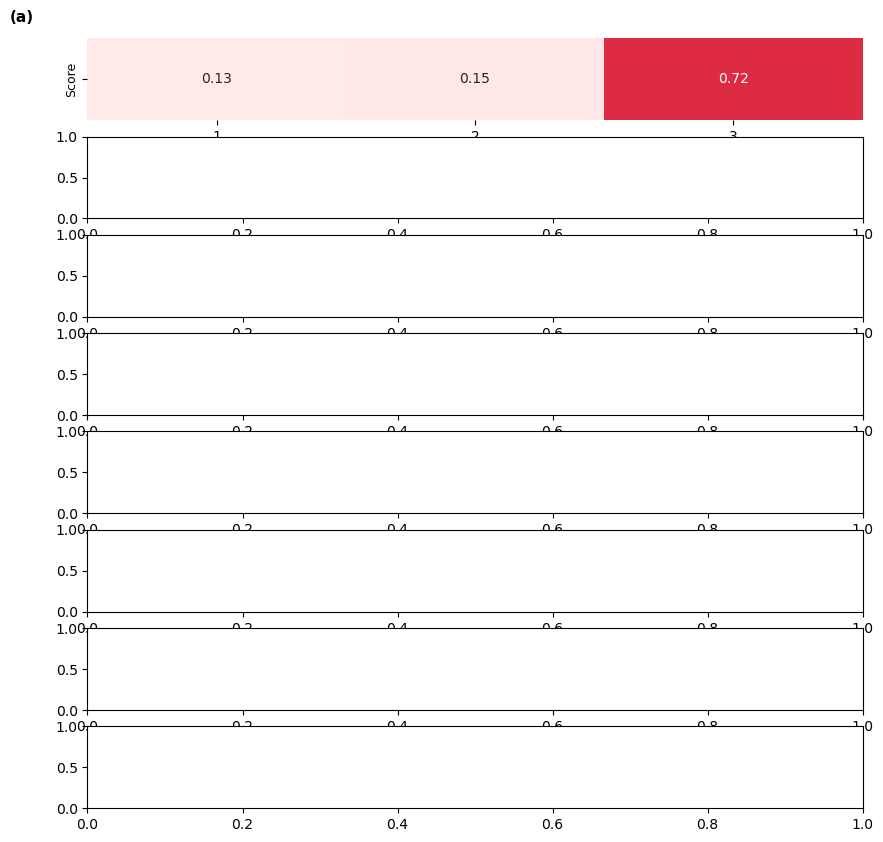

In [44]:
# @title Interactive tool
import ipywidgets as widgets

nr_articles_for_heatmap = 8
list_of_widgets = []
style = {'description_width': 'initial'}

for i in range(nr_articles_for_heatmap):
    widget_i = widgets.BoundedIntText(
        value=i+4,
        min=0,
        max=1761,
        step=1,
        description=f'Text Index:',
        style=style,
        layout=widgets.Layout(width='80%')
    )
    list_of_widgets.append(widget_i)

alpha_slider = widgets.FloatSlider(
    value=15,
    min=0,
    max=50,
    step=0.1,
    description='Alpha:',
    style=style,
    layout=widgets.Layout(width='90%')
)

metric = widgets.RadioButtons(
    options=['euclidean', 'cosine', 'cityblock'],
    description='Metric:',
    value='cosine',
    style=style,
    layout=widgets.Layout(width='100%')
)

scaling = widgets.RadioButtons(
    options=['power', 'exponential'],
    description='Scaling:',
    value='exponential',
    style=style,
    layout=widgets.Layout(width='100%')
)

for wid in list_of_widgets:
    wid.observe(update_heatmap, names='value')

alpha_slider.observe(update_heatmap, names='value')
metric.observe(update_heatmap, names='value')
scaling.observe(update_heatmap, names='value')


widgets_box_top = widgets.VBox(list_of_widgets[0:4], layout=widgets.Layout(width='20%'))
widgets_box_low = widgets.VBox(list_of_widgets[4:], layout=widgets.Layout(width='20%'))
sub_widget_box_low = widgets.HBox([metric, scaling], layout=widgets.Layout(width='100%'))
widgets_box_lowest = widgets.VBox([alpha_slider, sub_widget_box_low], layout=widgets.Layout(width='30%'))
widgets_box = widgets.HBox([widgets_box_top, widgets_box_low, widgets_box_lowest])

# Output widget
output = widgets.Output()

# Display initial heatmap
with output:
    plot_heatmap([wid.value for wid in list_of_widgets], alpha_slider.value, metric.value, scaling.value, category_names)

display(widgets_box, output)


It may be useful to see the aggregate scores in a pie chart. First, set the parameters found in the previous sections. Then, create the chart by summing the scores per category.

In [45]:
alpha = 10
metric = 'cosine'
scaling = 'exponential'

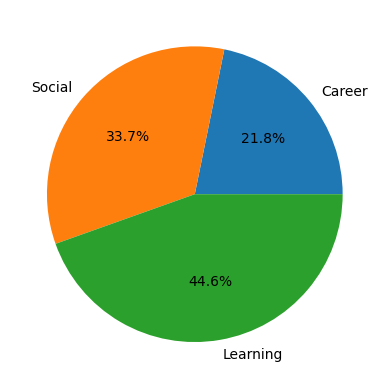

In [46]:
scores = embedding_score(text_embeddings, centroid_embeddings, alpha, metric, scaling)
aggregate=np.sum(scores, axis=0)

plt.pie(aggregate, labels=category_names, autopct="%1.1f%%")
plt.show()